### AlphaPilot - Predict Gate Regions

In [55]:
'''
TODO
[ ] process data
    [x] upload imgs
    [ ] upload labels
        [x] truth_new.json upload
        [ ] figure out which truth dataset
        [ ]
    [ ] unzip data
    [ ] find old processing script
        [ ] eliminate 9th data point (?)
    [ ] align number of labels with number of images
    
    
[ ] Build ImagePoint data set

[ ] Packaging / sourcing
    [ ] git between cloud and local
    [ ] run the processing on both

'''
pass

In [1]:
import os, sys, json, copy, random
import pandas as pd
import numpy as np
from fastai.vision import *

In [2]:
#cloud
data_dir = Path('data/alphapilot/')

zip_fn = data_dir/'Data_Training.zip'
raw_fn = data_dir/'data_training'
label_fn = data_dir/'truth_new.json'

#local
if os.name == 'nt':
    
    data_dir = Path('../../../../alphapilot/')
    
    #from os.getcwd() == files/fastai/course-v3/nbs/custom
    zip_fn = data_dir/'Data_Training.zip'
    raw_fn = data_dir/'Data_Training/Data_Training/'
    label_fn = data_dir/'truth_new.json'

##### Build Data on Cloud

In [8]:
if os.name != 'nt':
    !unzip str(zip_fn) str(raw_fn)

##### Build fastai object with y-data "ground truth"
modelers given in json file with img name and truth

truth_new.json contains all manually revised and corrected bbox's

there are only 5381 corrected labels for 9339 training images.

there are 5827 non-blank bbox correct images, these are in truth_1dim (dict) and truth_df (DF)

In [3]:
with open(label_fn, 'r') as f:
    truth = json.load(f)

print('truth:', *list(truth.items())[:2], sep='\n')

list_blanks = [k for k,v in truth.items()
                 if len(v[0]) == 0]

print('\nall blank images: ', list_blanks)

truth_1dim = {k:v[0] for k,v in truth.items() 
                      if k not in list_blanks
             }

print('\ntruth_1dim:', *list(truth_1dim.items())[:2], sep='\n')

print( '\ndifference in length: '
       ,len(list(truth.items())) 
       ,len(list(truth_1dim.items()))
     )

truth:
('IMG_9622.JPG', [[583, 439, 772, 431, 779, 628, 582, 631]])
('IMG_9925.JPG', [[481, 295, 769, 268, 777, 590, 480, 589]])

all blank images:  ['IMG_1343.JPG', 'IMG_0688.JPG', 'IMG_6608.JPG', 'IMG_0492.JPG']

truth_1dim:
('IMG_9622.JPG', [583, 439, 772, 431, 779, 628, 582, 631])
('IMG_9925.JPG', [481, 295, 769, 268, 777, 590, 480, 589])

difference in length:  5831 5827


In [4]:
truth_df = pd.DataFrame(truth_1dim)

In [5]:
truth_df.T.head()

,0,1,2,3,4,5,6,7
IMG_9622.JPG,583,439,772,431,779,628,582,631
IMG_9925.JPG,481,295,769,268,777,590,480,589
IMG_6733.JPG,593,362,650,399,649,597,589,592
IMG_4583.JPG,477,292,722,278,723,560,479,549
IMG_0401.JPG,522,321,657,344,650,554,519,569


In [171]:
'''
Questions:

- how does the label-data in head-pose setup / how is it imported?
   - 15K training images, 500 validation images
   - data.valid_dl.y.get(i).data -> e.g. tensor([[ 0.0297, -0.0363]])
   - 
- does fastai.bbox allow no rect, e.g. polygons?


Definitions:

.filter_by_func() - what I'm looking for to reduce the x-data

PointsLabelList - applies the transform 

                    .get(i) return the points scaled

PointsProcessor sets LabelList.c = number of distinct points to target

ImagePoints - "Support applying transforms to a `flow` of points."
        
                    y_first=True (by default)

ImageBBox

ImgList - 
                    imglist.train.x.get(i) - returns data at i
                    imglist.train.x.items[i] - returns path pointer to img at i

Example of coords in head-pose:

['0.637035 0.0358445 -0.770001 \n',
 '0.152652 0.973268 0.171598 \n',
 '0.755569 -0.226856 0.614534 \n',
 '\n',
 '215.355 36.4714 894.197 \n',
 '\n']

'''
pass

##### Build FastAI objects

we want to do a reprocducible validation, and test split here

we want to align with only truth_new.json object, and only those with non-blank bbox

PointsItemList <- PointsLabelList(y) + ImageList(x)

In [39]:
# build the master class PointsItemList
gate_data = PointsItemList.from_folder(raw_fn)

In [40]:
#filter the records without a corrected, or a blank ground truth

TRUTH_INDS  = list(truth_df.columns)
def filter_img_by_truth(fn):
    return fn.name in TRUTH_INDS

filter_records = filter_img_by_truth

len0 = len(gate_data)

gate_data.filter_by_func(filter_records)

len1 = len(gate_data)

print('dataset reduced from len: %i to len: %i' % (len0, len1))

dataset reduced from len: 9339 to len: 5827


In [41]:
#split the data into train/validation
np.random.seed(42)

gate_data = gate_data.split_by_rand_pct(valid_pct=0.2)

print('num records in train: %i ; and in validation: %i' 
      % (len(gate_data.train.items), len(gate_data.valid.items)))

num records in train: 4662 ; and in validation: 1165


In [42]:
# build label data from json into dataset
def label_points(fn):
    '''
        input:  x0,y0,...x3,y3 (list)
        output: [y0,x0],...[y3,x3] (list) 
         
        >use y_first=True in label-load-func
    '''
    p = truth_df[fn.name]
    return tensor([ [ float(p[i*2+1]), float(p[i*2+0]) ] for i in range(4)])

gate_data = gate_data.label_from_func(label_points, )

##### Verify the Data Matches via plots
look for red '+' in the corners of the gate

IMG_0006.JPG
tensor([[210., 307.],
        [238., 609.],
        [527., 610.],
        [533., 305.]])


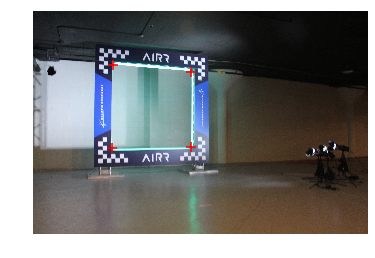

In [43]:
i = 1

fn =  gate_data.train.x.items[i]
img = gate_data.train.x.get(i)
pts = gate_data.train.y.items[i]

def get_ip(img,pts): 
    return ImagePoints(FlowField(img.size, pts), 
                       scale=True,  
                       y_first=True)

print(fn.name)
print(pts)
img.show(y=get_ip(img, pts), figsize=(6, 6), c='r', marker='+', s=100, hide_axis=False)

##### Normalize the dataset
we can experiment with different parameters here

In [44]:
img0 = gate_data.train.x.get(0)
img0.shape

torch.Size([3, 864, 1296])

In [45]:
def mod_img_divisor(h,w):
    return [ i for i in range(2, min(h,w) // 2) 
               if (h % i ==0) and (w % i ==0 )
           ]
divisors = mod_img_divisor(*list(img0.shape)[1:])

[tensor(img0.shape[1:]) / e for e in divisors]

[tensor([432, 648]),
 tensor([288, 432]),
 tensor([216, 324]),
 tensor([144, 216]),
 tensor([108, 162]),
 tensor([ 96, 144]),
 tensor([ 72, 108]),
 tensor([54, 81]),
 tensor([48, 72]),
 tensor([36, 54]),
 tensor([32, 48]),
 tensor([24, 36]),
 tensor([18, 27]),
 tensor([16, 24]),
 tensor([12, 18]),
 tensor([ 8, 12]),
 tensor([6, 9]),
 tensor([4, 6])]

In [46]:
gate_data = gate_data.transform(get_transforms(), tfm_y=True, size=(108,162))    

In [47]:
gate_data

LabelLists;

Train: LabelList (4662 items)
x: PointsItemList
Image (3, 108, 162),Image (3, 108, 162),Image (3, 108, 162),Image (3, 108, 162),Image (3, 108, 162)
y: PointsLabelList
ImagePoints (108, 162),ImagePoints (108, 162),ImagePoints (108, 162),ImagePoints (108, 162),ImagePoints (108, 162)
Path: ..\..\..\..\alphapilot\Data_Training\Data_Training;

Valid: LabelList (1165 items)
x: PointsItemList
Image (3, 108, 162),Image (3, 108, 162),Image (3, 108, 162),Image (3, 108, 162),Image (3, 108, 162)
y: PointsLabelList
ImagePoints (108, 162),ImagePoints (108, 162),ImagePoints (108, 162),ImagePoints (108, 162),ImagePoints (108, 162)
Path: ..\..\..\..\alphapilot\Data_Training\Data_Training;

Test: None

In [48]:
gate_bunch = gate_data.databunch(bs=16)

assert isinstance(gate_bunch, ImageDataBunch)

In [ ]:
data_final = gate_bunch.normalize(imagenet_stats)

assert isinstance(data_final, ImageDataBunch)

In [51]:
data_final

ImageDataBunch;

Train: LabelList (4662 items)
x: PointsItemList
Image (3, 108, 162),Image (3, 108, 162),Image (3, 108, 162),Image (3, 108, 162),Image (3, 108, 162)
y: PointsLabelList
ImagePoints (108, 162),ImagePoints (108, 162),ImagePoints (108, 162),ImagePoints (108, 162),ImagePoints (108, 162)
Path: ..\..\..\..\alphapilot\Data_Training\Data_Training;

Valid: LabelList (1165 items)
x: PointsItemList
Image (3, 108, 162),Image (3, 108, 162),Image (3, 108, 162),Image (3, 108, 162),Image (3, 108, 162)
y: PointsLabelList
ImagePoints (108, 162),ImagePoints (108, 162),ImagePoints (108, 162),ImagePoints (108, 162),ImagePoints (108, 162)
Path: ..\..\..\..\alphapilot\Data_Training\Data_Training;

Test: None

##### Verify the transforms worked
y-point-labels are being scaled with image size
verify images are the size they claim to be

IMG_0006.JPG
torch.Size([864, 1296])
tensor([[210., 307.],
        [238., 609.],
        [527., 610.],
        [533., 305.]])


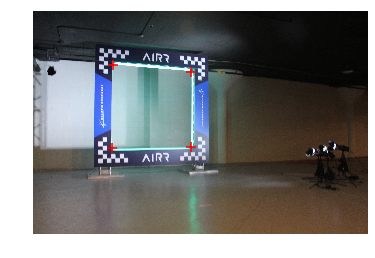

In [53]:
i = 1

fn =  data_final.train_dl.x.items[i]
img = data_final.train_dl.x.get(i)
pts = data_final.train_dl.y.items[i]

def get_ip(img,pts): 
    return ImagePoints(FlowField(img.size, pts), 
                       scale=True,  
                       y_first=True)

print(fn.name)
print(img.size)
print(pts)
img.show(y=get_ip(img, pts), figsize=(6, 6), c='r', marker='+', s=100, hide_axis=False)

##### Model fit

In [59]:
learn = cnn_learner(data_final, models.resnet34)

In [60]:
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


BrokenPipeError: [Errno 32] Broken pipe

In [ ]:
lr = 2e-2

In [ ]:
learn.fit_one_cycle(5, slice(lr))

##### Others/Misc

In [ ]:
# verify that each corner is logically in-bounds + relative ot each other, "convex space"